# library

In [137]:
import re
import six
import math
import lmdb
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import json
import cv2

import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
from IPython.display import display

from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.utils import Sequence, plot_model
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model

import keras_ocr

# GPU

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # 메모리 사용 제한을 위한 설정
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    # 특정 GPU만 사용하도록 설정
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
  except RuntimeError as e:
    # 프로그램 시작 후에는 GPU 설정을 변경할 수 없으므로
    # 런타임 오류 발생 시 예외 처리가 필요함
    print(e)

Num GPUs Available:  1


# Data

* 사용할 데이터셋 [MJSynth]( https://www.robots.ox.ac.uk/~vgg/data/text/ )
* Recognition model의 정량적인 평가를 위해서 MJSynth와 [SynthText]( https://www.robots.ox.ac.uk/~vgg/data/scenetext/ ) 라는 데이터셋 활용

In [32]:
DATA_DIR = '../GD6/data'
TRAIN_DATA_PATH = DATA_DIR + '/MJ/MJ_train'
TEST_DATA_PATH = DATA_DIR + '/MJ/MJ_test'
VALID_DATA_PATH = DATA_DIR + '/MJ/MJ_valid'

BATCH_SIZE = 128

# data 확인

* LMDB: Symas에서 만든 Lightning Memory-Mapped Database 의 약자

----------------------------------------------
original image width:72, height:31
target_img_size:(74, 32)
display img shape:(74, 32, 3)
label:Lube


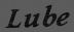

----------------------------------------------
original image width:82, height:31
target_img_size:(84, 32)
display img shape:(84, 32, 3)
label:Spencerian


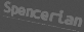

----------------------------------------------
original image width:115, height:31
target_img_size:(100, 32)
display img shape:(100, 32, 3)
label:accommodatingly


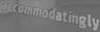

----------------------------------------------
original image width:140, height:31
target_img_size:(100, 32)
display img shape:(100, 32, 3)
label:CARPENTER


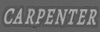

In [17]:
# env에 데이터를 불러올게요
# lmdb에서 데이터를 불러올 때 env라는 변수명을 사용하는게 일반적이에요
env = lmdb.open(TRAIN_DATA_PATH, 
                max_readers=32, 
                readonly=True, 
                lock=False, 
                readahead=False, 
                meminit=False)

# 불러온 데이터를 txn(transaction)이라는 변수를 통해 엽니다
# 이제 txn변수를 통해 직접 데이터에 접근 할 수 있어요
with env.begin(write=False) as txn:
    for index in range(1, 5):
        print('----------------------------------------------')
        # index를 이용해서 라벨 키와 이미지 키를 만들면
        # txn에서 라벨과 이미지를 읽어올 수 있어요
        
        # 인덱스를 사용하여 LMDB 데이터베이스의 레이블에 대한 키를 구성합니다.
        label_key = 'label-%09d'.encode() % index
        # LMDB 데이터베이스에서 현재 인덱스와 연결된 레이블을 검색합니다.
        label = txn.get(label_key).decode('utf-8')
        # 인덱스를 사용하여 LMDB 데이터베이스에 이미지에 대한 키를 구성합니다.
        img_key = 'image-%09d'.encode() % index
        # LMDB 데이터베이스에서 현재 인덱스와 연결된 이미지 데이터(바이트)를 검색합니다.
        imgbuf = txn.get(img_key)
        # 이미지 데이터를 BytesIO 버퍼에 쓰고 버퍼 위치를 시작 부분으로 설정합니다
        buf = six.BytesIO()
        buf.write(imgbuf)
        buf.seek(0)

        # 이미지는 버퍼를 통해 읽어오기 때문에 
        # 버퍼에서 이미지로 변환하는 과정이 다시 필요해요
        try:
            img = Image.open(buf).convert('RGB')

        except IOError:
            img = Image.new('RGB', (100, 32))
            label = '-'

        # 원본 이미지 크기를 출력해 봅니다
        width, height = img.size
        print('original image width:{}, height:{}'.format(width, height))
        
        # 이미지 비율을 유지하면서 높이를 32로 바꿀거에요
        # 하지만 너비를 100보다는 작게하고 싶어요
        target_width = min(int(width*32/height), 100)
        target_img_size = (target_width,32)        
        print('target_img_size:{}'.format(target_img_size))      
        # Resizes the image to the target size and transposes the dimensions to match the desired shape.
        img = np.array(img.resize(target_img_size)).transpose(1,0,2)

        # 이제 높이가 32로 일정한 이미지와 라벨을 함께 출력할 수 있어요
        # Prints the shape of the displayed image and the associated label. Displays the image using the display function
        print('display img shape:{}'.format(img.shape))
        print('label:{}'.format(label))
        display(Image.fromarray(img.transpose(1,0,2).astype(np.uint8)))

1. env.begin(write=False)를 사용하여 읽기 전용 트랜잭션을 엽니다.
2. 반복문을 통해 인덱스를 이용하여 라벨 키와 이미지 키를 만들고, 해당 키로부터 라벨과 이미지를 읽어옵니다.
3. 이미지는 LMDB에서 바이트로 읽어오고, 이를 six.BytesIO()를 사용하여 이미지로 변환합니다.
4. PIL(Python Imaging Library)을 사용하여 이미지를 열고, RGB로 변환합니다.
5. 원본 이미지의 크기를 출력하고, 이미지의 높이를 32로 고정하면서 비율을 유지하여 이미지의 크기를 조정합니다.
6. 최종적으로 조정된 이미지와 라벨을 출력합니다.

* 이 코드는 LMDB 데이터베이스에서 이미지와 라벨을 가져와서 이를 조정된 크기로 변환하여 출력하는 코드입니다.

---
---
class MJDatasetSequence(Sequence)

* _get_img_label()
    * 이미지 데이터를 img, label 의 쌍으로 가져오는 메서드
    * 다양한 사이즈의 이미지를 모두 height 는 32, width 는 최대 100 이 되도록 가공
    
* __ getitem__()
    * 배치 단위만큼 _get_img_label()을 통해 가져온 데이터셋 리턴
    * idx에 해당하는 index_list만큼 데이터 불러오기
    * image와 label을 불러오기
    * 사용하기 좋은 inputs과 outputs형태로 반환

In [18]:
class MJDatasetSequence(Sequence):
    # 객체를 초기화 할 때 lmdb를 열어 env에 준비해둡니다
    # 또, lmdb에 있는 데이터 수를 미리 파악해둡니다
    def __init__(self, 
                dataset_path,
                label_converter,
                batch_size=1,
                img_size=(100,32),
                max_text_len=22,
                is_train=False,
                character='') :
        
        self.label_converter = label_converter  # 문자를 미리 정의된 index로 변환해주는 converter
        self.batch_size = batch_size  # 배치 사이즈
        self.img_size = img_size  # 입력 이미지 크기
        self.max_text_len = max_text_len  # 최대 글자 수
        self.character = character  # 학습 대상으로 한정하기 위한 character
        self.is_train = is_train
        self.divide_length = 100

        self.env = lmdb.open(dataset_path, max_readers=32, readonly=True, lock=False, readahead=False, meminit=False)
        with self.env.begin(write=False) as txn:
            self.num_samples = int(txn.get('num-samples'.encode()))
            self.index_list = [index + 1 for index in range(self.num_samples)]
        

    def __len__(self):
        return math.ceil(self.num_samples/self.batch_size/self.divide_length)
    
    # index에 해당하는 image와 label을 읽어옵니다
    # 위에서 사용한 코드와 매우 유사합니다
    # label을 조금 더 다듬는 것이 약간 다릅니다

    # - 이미지 데이터를 img, label 의 쌍으로 가져오는 메서드
    # => 다양한 사이즈의 이미지를 모두 height 는 32, width 는 최대 100 이 되도록 가공
    def _get_img_label(self, index):
        with self.env.begin(write=False) as txn:
            label_key = 'label-%09d'.encode() % index
            label = txn.get(label_key).decode('utf-8')
            img_key = 'image-%09d'.encode() % index
            imgbuf = txn.get(img_key)

            buf = six.BytesIO()
            buf.write(imgbuf)
            buf.seek(0)
            try:
                img = Image.open(buf).convert('RGB')

            except IOError:
                img = Image.new('RGB', self.img_size)
                label = '-'
            width, height = img.size
            
            target_width = min(int(width*self.img_size[1]/height), self.img_size[0])
            target_img_size = (target_width, self.img_size[1])
            img = np.array(img.resize(target_img_size)).transpose(1,0,2)
            # label을 약간 더 다듬습니다
            label = label.upper()
            out_of_char = f'[^{self.character}]'
            label = re.sub(out_of_char, '', label)
            label = label[:self.max_text_len]

        return (img, label)
    
    # __getitem__은 약속되어있는 메서드입니다
    # 이 부분을 작성하면 slice할 수 있습니다
    # 자세히 알고 싶다면 아래 문서를 참고하세요
    # https://docs.python.org/3/reference/datamodel.html#object.__getitem__

    # - model.fit() 에서 호출되는 메서드: 배치 단위만큼 _get_img_label()을 통해 가져온 데이터셋 리턴
    def __getitem__(self, idx):
        # 1. idx에 해당하는 index_list만큼 데이터를 불러
        batch_indicies = self.index_list[
            idx*self.batch_size:
            (idx+1)*self.batch_size
        ]
        input_images = np.zeros([self.batch_size, *self.img_size, 3])
        labels = np.zeros([self.batch_size, self.max_text_len], dtype='int64')

        input_length = np.ones([self.batch_size], dtype='int64') * self.max_text_len
        label_length = np.ones([self.batch_size], dtype='int64')

        # 2. image와 label을 불러오고 
        for i, index in enumerate(batch_indicies):
            img, label = self._get_img_label(index)
            encoded_label = self.label_converter.encode(label)
            # 인코딩 과정에서 '-'이 추가되면 max_text_len보다 길어질 수 있어요
            if len(encoded_label) > self.max_text_len:
                continue
            width = img.shape[0]
            input_images[i,:width,:,:] = img
            labels[i,0:len(encoded_label)] = encoded_label
            label_length[i] = len(encoded_label)
        
        # 3. 사용하기 좋은 inputs과 outputs형태로 반환합니다
        inputs = {
            'input_image': input_images,
            'label': labels,
            'input_length': input_length,
            'label_length': label_length,
        }
        outputs = {'ctc': np.zeros([self.batch_size, 1])}

        return inputs, outputs

In [20]:
class LabelConverter(object):

    # 입력으로 받은 text를 self.dict 에 각 character 들이 어떤 index 에 매핑되는지 저장
    # => character, index 를 통해 모델이 학습할 수 있는 output 이 생성됨
    def __init__(self, character):
        self.character = "-" + character
        self.label_map = dict()
        for i, char in enumerate(self.character):
            self.label_map[char] = i
            
            
    # print 실행시 효과적인 결과가 나오기 위해 추가
    def __str__(self):
        return f"LabelConverter for characters: {self.character}"

            
    # character -> index 변환
    # cf. 공백 문자를 뜻하는 '-' 의 label 은 0 으로 지정
    def encode(self, text):
        encoded_label = []
        for i, char in enumerate(text):
            if i > 0 and char == text[i - 1]:
                encoded_label.append(0)    # 같은 문자 사이에 공백(blank) 문자 label을 삽입
            encoded_label.append(self.label_map[char])

        return np.array(encoded_label)

    # index -> character 변환
    # => 사람이 읽을 수 있는 text 로 변경
    def decode(self, encoded_label):
        target_characters = list(self.character)
        decoded_label = ""
        for encode in encoded_label:
            decoded_label += self.character[encode]
        return decoded_label

In [21]:
NUMBERS = "0123456789"
ENG_CHAR_UPPER = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
TARGET_CHARACTERS = ENG_CHAR_UPPER + NUMBERS
print(f"The total number of characters is {len(TARGET_CHARACTERS)}")

The total number of characters is 36


In [29]:
label_converter = LabelConverter(TARGET_CHARACTERS)
print(label_converter)
encdoded_text = label_converter.encode('HELLLLLO')
print("Encdoded_text: ", encdoded_text)  
decoded_text = label_converter.decode(encdoded_text)
print("Decoded_text: ", decoded_text)  

LabelConverter for characters: -ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789
Encdoded_text:  [ 8  5 12  0 12  0 12  0 12  0 12 15]
Decoded_text:  HEL-L-L-L-LO


In [35]:
train_set = MJDatasetSequence(TRAIN_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS, is_train=True)
val_set = MJDatasetSequence(VALID_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS)
test_set = MJDatasetSequence(TEST_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS)

print(f'Train DataSet 개수: {len(train_set)}')  # 565
print(f'Valid DataSet 개수: {len(val_set)}')  # 63
print(f'Test DataSet 개수: {len(test_set)}')  # 70

Train DataSet 개수: 565
Valid DataSet 개수: 63
Test DataSet 개수: 70


In [37]:
print(train_set.batch_size)

128


# CTC

* [Tensorflow Tutorial - ctc_batch_cost](https://www.tensorflow.org/versions/r2.2/api_docs/python/tf/keras/backend/ctc_batch_cost)

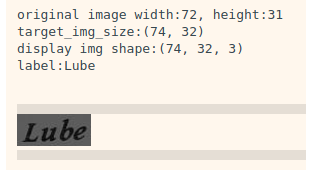

* Keras 제공 K.ctc_batch_cost() 사용 (samples == batch_size)
    * y_true: tensor (samples, max_string_length) containing the truth labels.
        * 실제 라벨 LUBE. 텍스트 라벨 그대로가 아니라, 각 글자를 One-hot 인코딩한 형태로서, max_string_length 값은 모델에서 22로 지정할 예정
    * y_pred: tensor (samples, time_steps, num_categories) containing the prediction, or output of the softmax.
        * 우리가 만들 RCNN 모델의 출력 결과. 길이는 4가 아니라 우리가 만들 RNN의 최종 출력 길이로서 24가 될 예정
    * input_length tensor: (samples, 1) containing the sequence length for each batch item in y_pred.
        * 모델 입력 길이 T로서, 이 경우에는 텍스트의 width인 74
    * label_length tensor: (samples, 1) containing the sequence length for each batch item in y_true.
        * 라벨의 실제 정답 길이 U로서, 이 경우에는 4
        
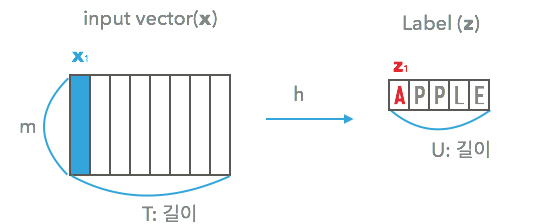

* 입력 길이 T != 라벨 길이 U 일 경우
    * 라벨 APPLE, 모델 출력 결과 AAAPPPPLLLLEE => 추론 결과: APLE
    * 라벨 AP-PLE 보정, 모델 출력 결과 AAAPPPPLLLLEE => 추론 결과: APPLE
        * 라벨 보정: LabelConverter.encode() 메서드에 공백문자 처리 로직이 포함됨

In [38]:
# CTC loss를 계산하기 위한 Lambda 함수
def ctc_lambda_func(args):
    labels, y_pred, label_length, input_length = args
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

# CRNN

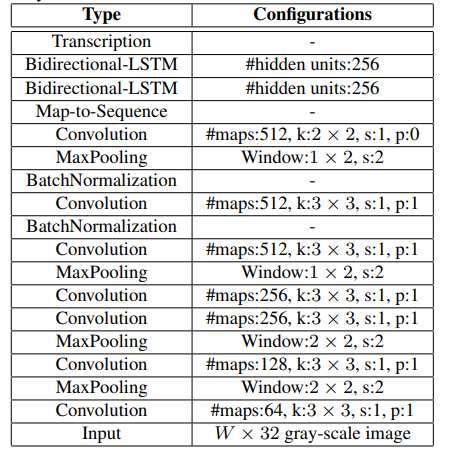

* [layers.Bidirectional](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Bidirectional)

* [layers.LSTM](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM)

In [50]:
def build_crnn_model(input_shape=(100,32,3), characters=TARGET_CHARACTERS):
    num_chars = len(characters)+2
    image_input = layers.Input(shape=input_shape, dtype='float32', name='input_image')
    
    # Build CRNN model
    # Conv Layers
    # Feature 추출
    conv = layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(image_input)
    conv = layers.MaxPooling2D(pool_size=(2, 2))(conv)
    conv = layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.MaxPooling2D(pool_size=(2, 2))(conv)
    conv = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.MaxPooling2D(pool_size=(1, 2))(conv)
    
    conv = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.BatchNormalization()(conv)
    conv = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.BatchNormalization()(conv)
    conv = layers.MaxPooling2D(pool_size=(1, 2))(conv)

    feature = layers.Conv2D(512, (2, 2), activation='relu', kernel_initializer='he_normal')(conv)

    # Recurrent Layers
    # 추출된 Feature 의 전체적인 Context 파악
    sequnce = layers.Reshape(target_shape=(24, 512))(feature)
    sequnce = layers.Dense(64, activation='relu')(sequnce)
    sequnce = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(sequnce)
    sequnce = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(sequnce)

    # Transcription Layer(=Fully Connected Layer)
    # Step 마다 어떤 Character 의 확률이 높은지 예측
    y_pred = layers.Dense(num_chars, activation='softmax', name='output')(sequnce)

    # CRNN 모델 생성
    labels = layers.Input(shape=[22], dtype='int64', name='label')
    input_length = layers.Input(shape=[1], dtype='int64', name='input_length')
    label_length = layers.Input(shape=[1], dtype='int64', name='label_length')
    loss_out = layers.Lambda(ctc_lambda_func, output_shape=(1,), name="ctc")(
        [labels, y_pred, label_length, input_length]
    )
    model_input = [image_input, labels, input_length, label_length]
    model = Model(inputs=model_input, outputs=loss_out)
    return model

In [51]:
model = build_crnn_model()

In [52]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, 100, 32, 3)] 0                                            
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 100, 32, 64)  1792        input_image[0][0]                
__________________________________________________________________________________________________
max_pooling2d_4 (MaxPooling2D)  (None, 50, 16, 64)   0           conv2d_7[0][0]                   
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, 50, 16, 128)  73856       max_pooling2d_4[0][0]            
____________________________________________________________________________________________

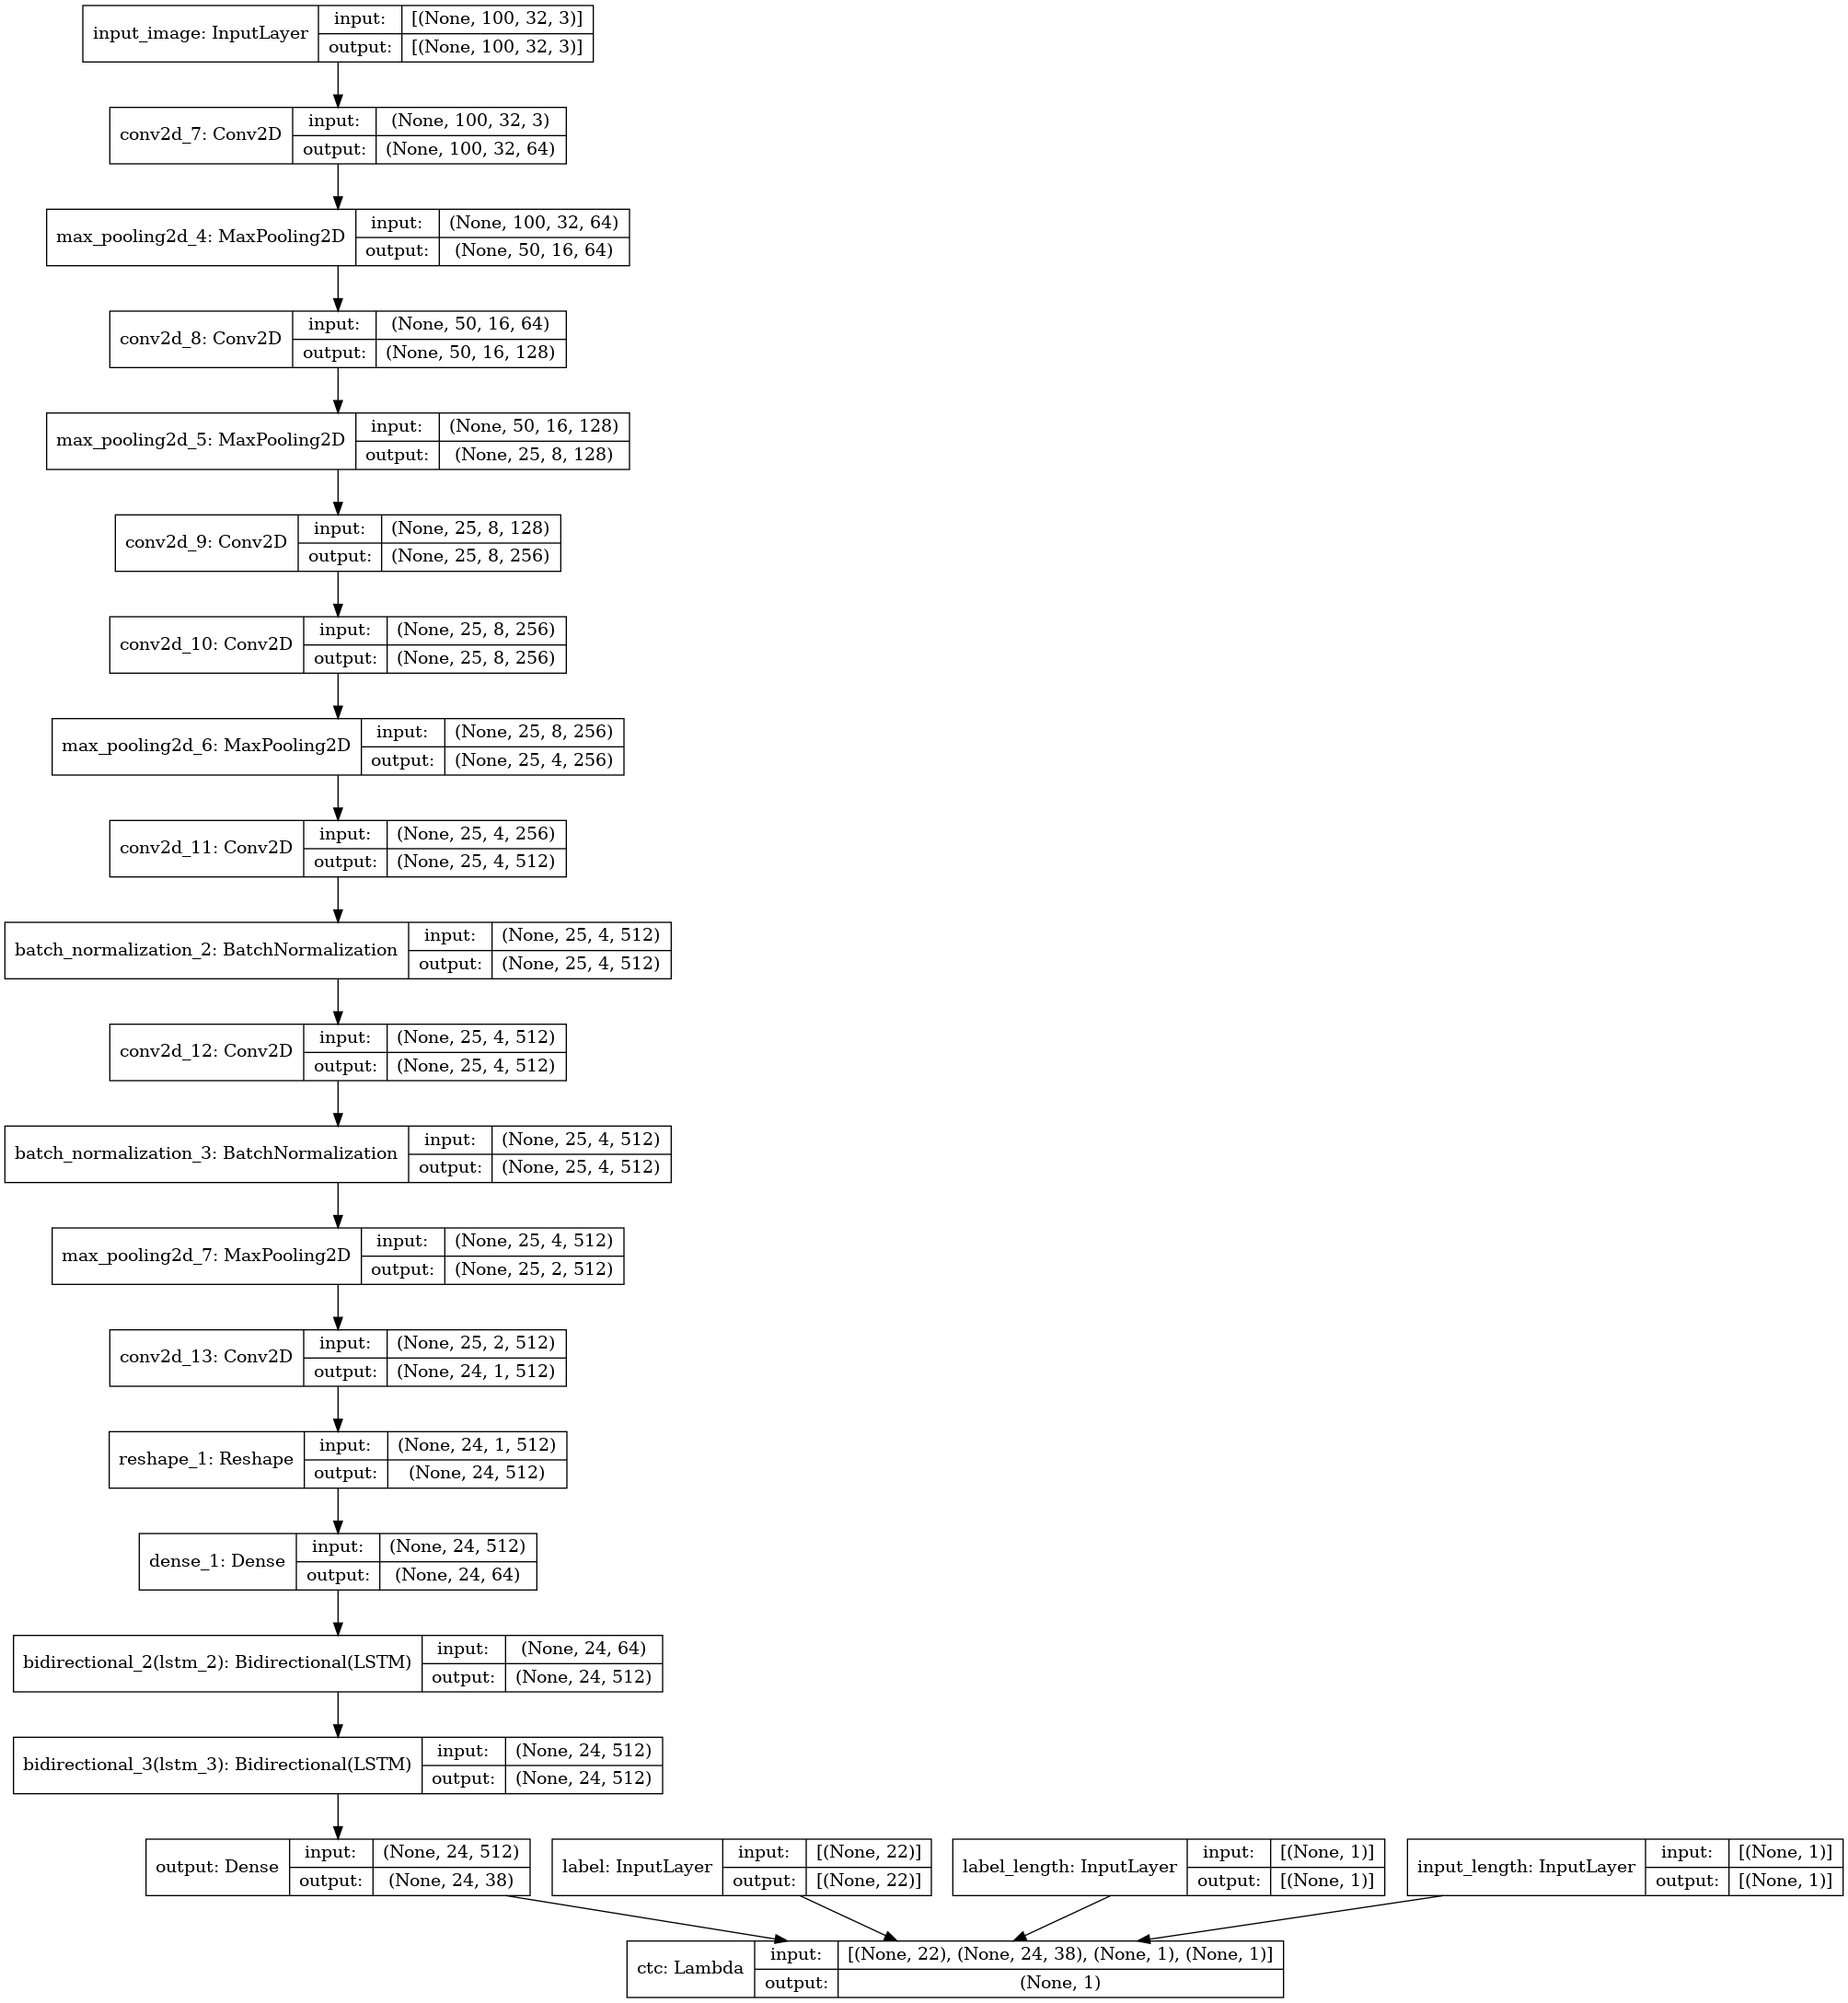

In [53]:
plot_model(model, show_shapes=True)

In [54]:
# 모델을 컴파일 합니다
optimizer = tf.keras.optimizers.Adadelta(learning_rate=0.1, clipnorm=5)
model.compile(
    optimizer=optimizer,
    loss={'ctc': lambda y_true, y_pred: y_pred},
    metrics=['accuracy'],
)

In [55]:
EPOCHS=50

In [56]:
# 훈련이 빨리 끝날 수 있도록 ModelCheckPoint를 사용합니다
checkpoint_path = DATA_DIR +  f'/model_checkpoint_{EPOCHS}.hdf5'
ckp = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path, monitor='val_loss',
    verbose=1, save_best_only=True, save_weights_only=True
)
crnn_history = model.fit(
    train_set,
    steps_per_epoch=len(train_set),
    epochs=EPOCHS,
    validation_data=val_set,
    validation_steps=len(val_set),
    callbacks=[ckp]
)

Epoch 1/50
565/565 [==============================] - 99s 163ms/step - loss: 25.7062 - accuracy: 0.0000e+00 - val_loss: 24.6386 - val_accuracy: 0.0000e+00

Epoch 00001: val_loss improved from inf to 24.63855, saving model to /model_checkpoint_50.hdf5
Epoch 2/50
565/565 [==============================] - 91s 161ms/step - loss: 16.3383 - accuracy: 7.7434e-04 - val_loss: 10.1684 - val_accuracy: 0.0024

Epoch 00002: val_loss improved from 24.63855 to 10.16837, saving model to /model_checkpoint_50.hdf5
Epoch 3/50
565/565 [==============================] - 85s 150ms/step - loss: 7.4363 - accuracy: 0.0731 - val_loss: 6.5585 - val_accuracy: 0.1370

Epoch 00003: val_loss improved from 10.16837 to 6.55852, saving model to /model_checkpoint_50.hdf5
Epoch 4/50
565/565 [==============================] - 84s 148ms/step - loss: 5.2723 - accuracy: 0.2290 - val_loss: 5.2640 - val_accuracy: 0.2691

Epoch 00004: val_loss improved from 6.55852 to 5.26398, saving model to /model_checkpoint_50.hdf5
Epoch 5/

565/565 [==============================] - 83s 147ms/step - loss: 0.0703 - accuracy: 0.9721 - val_loss: 6.8248 - val_accuracy: 0.6034

Epoch 00040: val_loss did not improve from 4.23195
Epoch 41/50
565/565 [==============================] - 84s 148ms/step - loss: 0.0645 - accuracy: 0.9736 - val_loss: 6.8822 - val_accuracy: 0.6047

Epoch 00041: val_loss did not improve from 4.23195
Epoch 42/50
565/565 [==============================] - 84s 148ms/step - loss: 0.0629 - accuracy: 0.9745 - val_loss: 6.8233 - val_accuracy: 0.6040

Epoch 00042: val_loss did not improve from 4.23195
Epoch 43/50
565/565 [==============================] - 85s 150ms/step - loss: 0.0627 - accuracy: 0.9751 - val_loss: 6.9996 - val_accuracy: 0.6050

Epoch 00043: val_loss did not improve from 4.23195
Epoch 44/50
565/565 [==============================] - 84s 149ms/step - loss: 0.0587 - accuracy: 0.9762 - val_loss: 7.1643 - val_accuracy: 0.6034

Epoch 00044: val_loss did not improve from 4.23195
Epoch 45/50
565/565 [=

In [62]:
checkpoint_path = DATA_DIR +  f'/model_checkpoint_{EPOCHS}.hdf5'
checkpoint_path

'../GD6/data/model_checkpoint_50.hdf5'

In [59]:
def draw_history(history, model_name='Recognition_CRNN'):
    plt.subplots(figsize=(12,4))

    # Model Loss, Validation Loss 시각화
    plt.subplot(121)
    plt.plot(history.history['loss'], 'r')
    plt.plot(history.history['val_loss'], 'b')
    plt.title(f'{model_name} Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['loss', 'val_loss'], loc='upper left')

    # Model Accuracy, Validation Accuracy 시각화
    plt.subplot(122)
    plt.plot(history.history['accuracy'], 'r')
    plt.plot(history.history['val_accuracy'], 'b')
    plt.title(f'{model_name} Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['accuracy', 'val_accuracy'], loc='upper left')

    plt.tight_layout()
    plt.show()

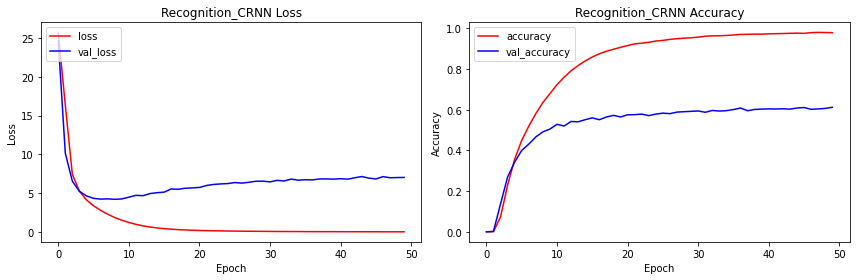

In [60]:
draw_history(crnn_history, 'Recognition_CRNN')

In [67]:
history_dict = crnn_history.history

# Save the dictionary to a JSON file
with open("crnn_history.json", 'w') as json_file:
    json.dump(history_dict, json_file)

In [70]:
JSON_PATH = '../GD6/crnn_history.json'
with open(JSON_PATH, 'r') as f:
    history=json.load(f)

In [72]:
def draw_call_history(history, model_name='Recognition_CRNN'):
    plt.subplots(figsize=(12,4))

    # Model Loss, Validation Loss 시각화
    plt.subplot(121)
    plt.plot(history['loss'], 'r')
    plt.plot(history['val_loss'], 'b')
    plt.title(f'{model_name} Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['loss', 'val_loss'], loc='upper left')

    # Model Accuracy, Validation Accuracy 시각화
    plt.subplot(122)
    plt.plot(history['accuracy'], 'r')
    plt.plot(history['val_accuracy'], 'b')
    plt.title(f'{model_name} Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['accuracy', 'val_accuracy'], loc='upper left')

    plt.tight_layout()
    plt.show()

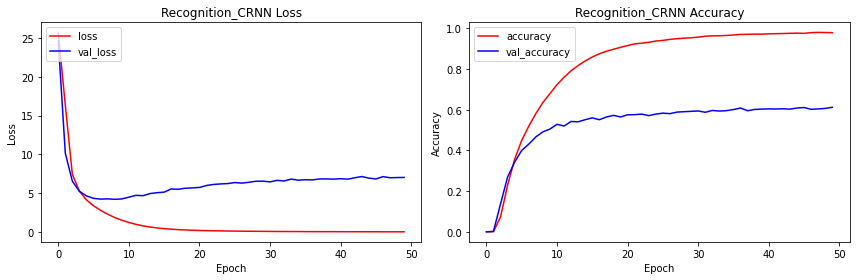

In [73]:
draw_call_history(history)

In [75]:
checkpoint_path = f'../GD6/model_checkpoint_{EPOCHS}.hdf5'
model.save(checkpoint_path)

In [76]:
# crnn 모델은 입력이 복잡한 구조이므로 그대로 사용할 수가 없습니다
# 그래서 crnn 모델의 입력중 'input_image' 부분만 사용한 모델을 새로 만들겁니다
# inference 전용 모델이에요 
input_data = model.get_layer('input_image').output
y_pred = model.get_layer('output').output
model_pred = Model(inputs=input_data, outputs=y_pred)

In [82]:
# 모델이 inference한 결과를 글자로 바꿔주는 역할을 합니다
# 코드 하나하나를 이해하기는 조금 어려울 수 있습니다
def decode_predict_ctc(out, chars = TARGET_CHARACTERS):
    results = []
    indexes = K.get_value(
        K.ctc_decode(
            out, input_length=np.ones(out.shape[0]) * out.shape[1],
            greedy=False , beam_width=5, top_paths=1
        )[0][0]
    )[0]
    text = ""
    for index in indexes:
        # 의미없는 인덱스 -1 위치 숫자 9 출력 방지
        if index == -1:
            continue
        # 예측한 문자 저장
        text += chars[index]
    return text

# 모델과 데이터셋이 주어지면 inference를 수행합니다
# index개 만큼의 데이터를 읽어 모델로 inference를 수행하고
# 결과를 디코딩해 출력해줍니다
def check_inference(model, dataset, index = 5):
    for i in range(index):
        print(f"----------------")
        inputs, outputs = dataset[i]
        img = inputs['input_image'][0:1,:,:,:]
        output = model.predict(img)  # 모델 예측

        # 예측
        result = decode_predict_ctc(output, chars="-"+TARGET_CHARACTERS).replace('-','')
        print(f"Result: \t{result}")
        
        # 라벨
        label = ''.join(map(lambda x: label_converter.decode(x), inputs['label'][0:1,])).replace('-','')
        print(f"Label:  \t{label}")

        # 예측, 라벨 인덱스별로 비교해서 같으면 1, 다르면 0 표시
        is_right = ''.join(map(lambda x: '1' if x[0] == x[1] else '0', zip(result, label)))
        print(f"Is_Right:\t{is_right}")

        # 맞춘 문자 개수, 점수 계산
        is_right_count = is_right.count('1')
        print(f"Is_Right_Count:\t{is_right_count}/{len(label)}")
        print(f"Score: {is_right_count/len(label):.2f}")

        display(Image.fromarray(img[0].transpose(1,0,2).astype(np.uint8)))

----------------
Result: 	SLINKING
Label:  	SLINKING
Is_Right:	11111111
Is_Right_Count:	8/8
Score: 1.00


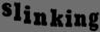

----------------
Result: 	ALEPPO
Label:  	ALEPPO
Is_Right:	111111
Is_Right_Count:	6/6
Score: 1.00


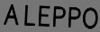

----------------
Result: 	FWANDE
Label:  	RWANDA
Is_Right:	011110
Is_Right_Count:	4/6
Score: 0.67


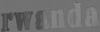

----------------
Result: 	NATHANS
Label:  	NATHANS
Is_Right:	1111111
Is_Right_Count:	7/7
Score: 1.00


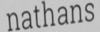

----------------
Result: 	HALBO
Label:  	HALLOO
Is_Right:	11101
Is_Right_Count:	4/6
Score: 0.67


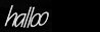

----------------
Result: 	HURLS
Label:  	HURLS
Is_Right:	11111
Is_Right_Count:	5/5
Score: 1.00


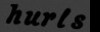

----------------
Result: 	DOWNSIZE
Label:  	DOWNSIZE
Is_Right:	11111111
Is_Right_Count:	8/8
Score: 1.00


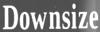

----------------
Result: 	ROBOTIC
Label:  	ROBOTIC
Is_Right:	1111111
Is_Right_Count:	7/7
Score: 1.00


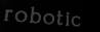

----------------
Result: 	SLOPPY
Label:  	SLOPPY
Is_Right:	111111
Is_Right_Count:	6/6
Score: 1.00


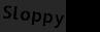

----------------
Result: 	THERMITE
Label:  	HERMITE
Is_Right:	0000000
Is_Right_Count:	0/7
Score: 0.00


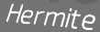

In [83]:
check_inference(model_pred, test_set, index=10)

# End to End OCR

In [111]:
SAMPLE_IMG_PATH = os.path.join(DATA_DIR, 'sample.jpg')
print(SAMPLE_IMG_PATH)
detector = keras_ocr.detection.Detector()

../GD6/data/sample.jpg
Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5


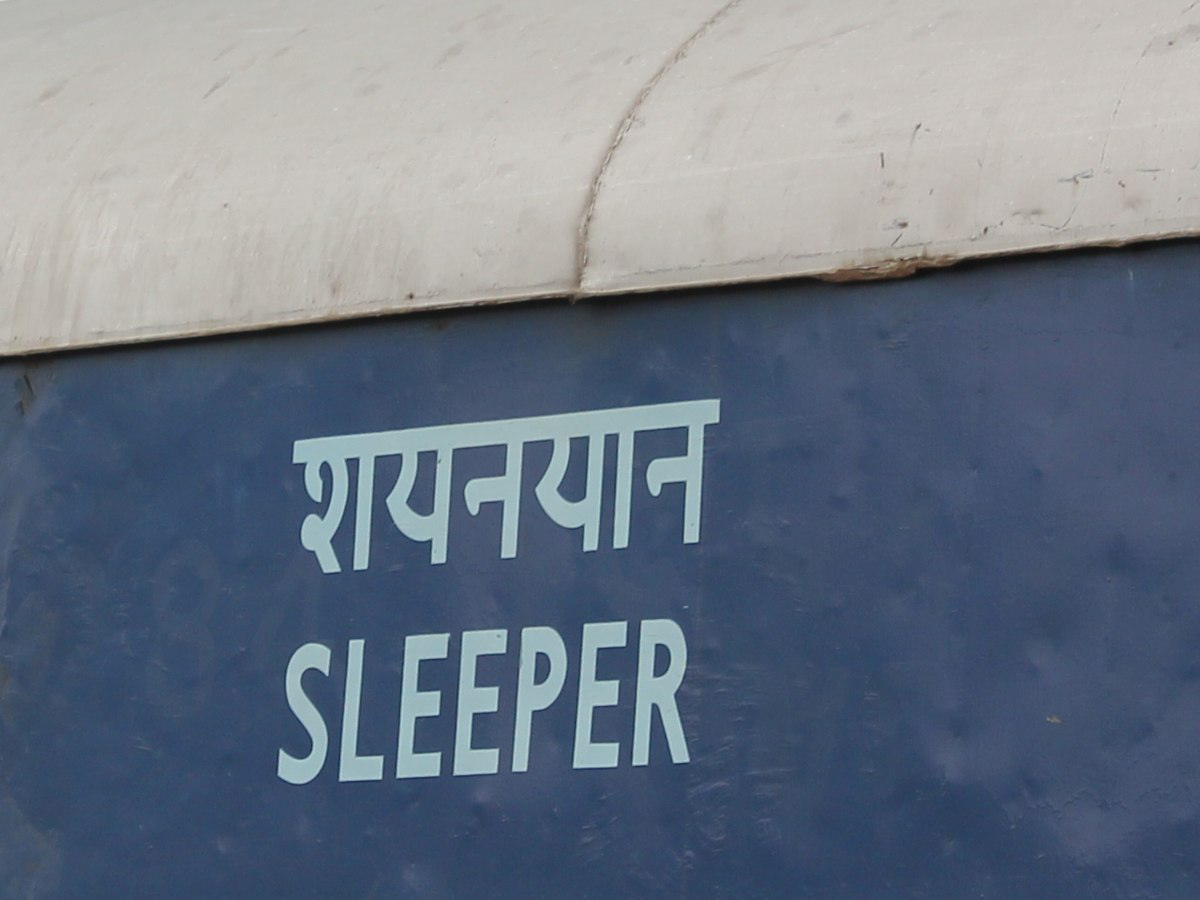

In [105]:
img_pil = Image.open(SAMPLE_IMG_PATH).convert('RGB')
img_pil

In [106]:
width, height = img_pil.size
print(width, height)

1200 900


In [107]:
target_width = min(int(width*300/height), 400)  # 이미지 비율 유지, 높이 300, 너비는 400 보다 작게 설정
target_img_size = (target_width,300)

In [108]:
img_pil = img_pil.resize(target_img_size)  # (400, 300, 3)
img_pil_copy = img_pil.copy()

print(img_pil.size)

(400, 300)


In [109]:
img_pil = np.array(img_pil)  # (300, 400, 3)
print(img_pil.size, img_pil.shape)

360000 (300, 400, 3)


In [110]:
img_pil = np.expand_dims(img_pil, axis=0)  # (1, 300, 400, 3)
print(img_pil.shape)

(1, 300, 400, 3)


In [131]:
def detect_text(img_path):
    # 배치 크기를 위해서 dimension을 확장해주고 keras-ocr의 입력 차원에 맞게 H,W,C로 변경
    result_img = Image.open(img_path)
    img_draw = ImageDraw.Draw(result_img)
    img = result_img.copy()
    img_pil = np.array(result_img)[np.newaxis, :, :, :]
    
    # 배치의 첫 번째 결과만 가져옵니다.
    ocr_result = detector.detect(img_pil)[0]
    
    cropped_imgs = []
    
    for text_result in ocr_result:
        img_draw.polygon(text_result, outline='red')
        x_min = text_result[:,0].min() - 5
        x_max = text_result[:,0].max() + 5
        y_min = text_result[:,1].min() - 5
        y_max = text_result[:,1].max() + 5
        word_box = [x_min, y_min, x_max, y_max]
        cropped_imgs.append(img.crop(word_box))

    return result_img, cropped_imgs

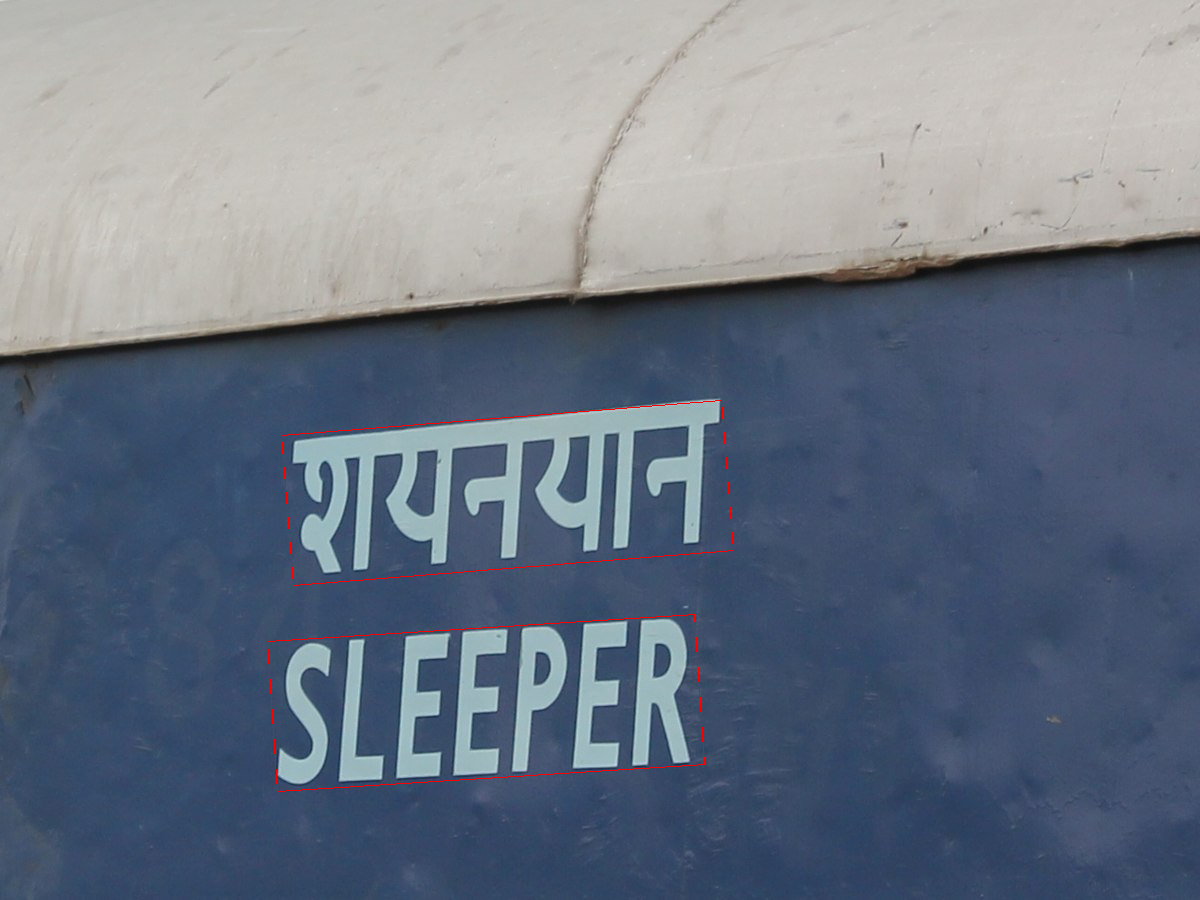

In [132]:
result_img, cropped_imgs = detect_text(SAMPLE_IMG_PATH)
display(result_img)

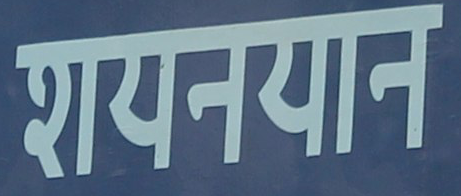

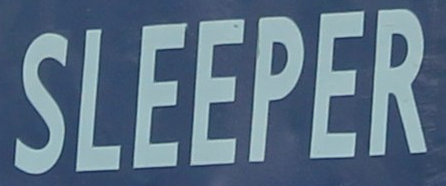

In [133]:
display(cropped_imgs[0])
display(cropped_imgs[1])

In [142]:
def recognize_img( pil_img, model_pred, input_img_size=(100,32)):
    # CRNN 기반의 Recognition 모델에 입력하기 위한 이미지 전처리
    # - 배치 크기 때문에 4 dims 로 확장
    # - shape=(W,H,C) 여야 모델 입력시 제대로 동작함
    pil_img = pil_img.resize(input_img_size)  # (100, 32, 3)
    pil_img = np.array(pil_img)  # (32, 100, 3)
    pil_img = pil_img.transpose(1,0,2)  # (100, 32, 3)
    pil_img = np.expand_dims(pil_img, axis=0)  # (1, 100, 32, 3)
    
    # 모델 예측
    # - OCR 텍스트 인식 결과 출력
    output = model_pred.predict(pil_img)
    result = decode_predict_ctc(output, chars="-"+TARGET_CHARACTERS).replace('-','')
    print("Result: \t", result)
    
    # display() 하기 위한 이미지 전처리
    # - 앞서 4 dims 로 확장시켰으므로 다시 3 dims 가 되도록 축소
    # - shape=(H,W,C) 여야 display() 에서 이미지가 제대로 그려짐
    pil_img = np.squeeze(pil_img, axis=0).transpose(1,0,2).astype(np.uint8)  # (32, 100, 3)
    pil_img = Image.fromarray(pil_img)
    display(pil_img)

Result: 	 PREARI


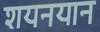

Result: 	 SLEEPER


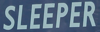

In [144]:
for _img in cropped_imgs:
    recognize_img(_img, model_pred)

# 회고


* rstrip 써도 9999 지울 수 있다. but gt 끝자리 9나와도 사라짐.-> 개선 완
* hermite, is right count, thermite로 나온거 결과 0임 -> 개선 방안 안떠오름
* transaction 사용 이유? mdb 파일 부를때 쓴다고 함. 맞나?
* transaction 쓸 때는 buf 많이 쓰는듯, 데이터 관리 및 속도 때문에
* np.array 쓰면 (W, H, C) -> (H, W, C) so, transpose(1,0,2) 
* dimension 확장 
    * np_img = np.reshape((1,) + np_img.shape)
    * np_img = np.expand_dims(np_img, axis=0)
    * np_img = np_img[np.newaxis, :, :, :]
    
* dimension 축소
    * np_img = np.squeeze(np_img, axis=0)
    
* detector = keras_ocr.detection.Detector()
* recognizer = keras_ocr.recognition.Recognizer() 이건 나중에 써보자

# 참조

* https://keras.io/examples/vision/captcha_ocr/
* https://github.com/faustomorales/keras-oc

# 추가

```python

# 모델을 컴파일 합니다
optimizer = tf.keras.optimizers.Adadelta(learning_rate=0.1, clipnorm=5)
model.compile(
    optimizer=optimizer,
    loss={'ctc': lambda y_true, y_pred: y_pred},
    metrics=['accuracy'],
)

EPOCHS = 50
checkpoint_dir = DATA_DIR  # Change this to the desired directory

# Define a custom callback to save model checkpoints at specific epochs
class SaveModelCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        save_epochs = [10, 20, 30, 40, 50]
        if epoch in save_epochs:
            checkpoint_path = os.path.join(checkpoint_dir, f'model_checkpoint_{epoch}.hdf5')
            self.model.save_weights(checkpoint_path)
            print(f"Saved model checkpoint at epoch {epoch}")

# ModelCheckpoint to save the best model based on validation loss
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    os.path.join(checkpoint_dir, 'best_model.hdf5'),
    monitor='val_loss', verbose=1,
    save_best_only=True, save_weights_only=True
)

# 학습을 진행합니다
crnn_history = model.fit(
    train_set,
    steps_per_epoch=len(train_set),
    epochs=EPOCHS,
    validation_data=val_set,
    validation_steps=len(val_set),
    callbacks=[SaveModelCallback(), model_checkpoint]
)

```

* save_best_only 랑 위 코드랑 실행 해서 6개 비교 해보고 싶었는데 시간 이슈 -> 아쉽
